# 1022 딥러닝응용 중간고사 (3)

### using dataset: url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'

1. 깃허브 자신의 계정에 수업과 숙제를 올린 소스코드만 참조가능
(그 외의 참조는 부정으로 간주 F처리)


데이터 로드
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=columns)

데이터 확인
print(data.head())

2) 해당 소스를 이용하여 ML 분류 RF, LR, DT
3) 해당 소스를 이용하여 FCNN
4) 해당 소스를 이용하여 CNN
5) 모든 소스에는 F1값 및 confusion matrix 표시

## 4) 해당 소스를 이용하여 CNN

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [47]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=columns)
print(data.head())

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


In [48]:
for i in data.columns:
    label_encoder = LabelEncoder()        
    data[i] = LabelEncoder().fit_transform(data[i])
data

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,1
1724,1,1,3,2,1,0,3
1725,1,1,3,2,0,1,2
1726,1,1,3,2,0,2,1


In [62]:
from collections import Counter

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [106]:
# 데이터 분류
X,y=split_sequences(data.values, 6)
y = pd.get_dummies(y).values
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0)
#X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape[1:])

(1723, 6, 6)
(1723, 4)
(6, 6)


In [124]:
from tensorflow.keras import Input, layers, Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Reshape, Conv2D

input_layer=Input(shape=X_train.shape[1:])
reshaped_input = Reshape((X_train.shape[1]*6,1 ,1))(input_layer)
layer1=layers.Conv2D(32, (1,1),activation="relu")(reshaped_input)
layer2=layers.Conv2D(48, (1,1),activation="relu")(layer1)
layer3=layers.Conv2D(64, (1,1),activation="relu")(layer2)
layer4=layers.Conv2D(96, (1,1),activation="relu")(layer3)

flatten=layers.Flatten()(layer4)
flatten_layer=layers.Dense(32,activation="relu")(flatten)
out_layer=layers.Dense(y_train.shape[1], activation="softmax")(flatten_layer)

model=Model(inputs=input_layer,outputs=out_layer)
model.compile(Adam(learning_rate=0.002),'categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 6, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_40 (Reshape)            │ (None, 36, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 36, 1, 32)      │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 36, 1, 48)      │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 36, 1, 64)      │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 36, 1, 96)      │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │       110,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,780 (475.70 KB)

 Trainable params: 121,780 (475.70 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# 딥러닝 훈련
n_epoch=10
history=model.fit(X_train,y_train, epochs=n_epoch, batch_size=4,validation_data= (X_test,y_test))

y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7454 - loss: 0.6115 - val_accuracy: 0.7401 - val_loss: 0.5579
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8310 - loss: 0.3928 - val_accuracy: 0.8028 - val_loss: 0.3988
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8693 - loss: 0.3064 - val_accuracy: 0.8376 - val_loss: 0.3615
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8832 - loss: 0.2700 - val_accuracy: 0.8213 - val_loss: 0.4220
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9028 - loss: 0.2402 - val_accuracy: 0.8724 - val_loss: 0.2576
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9232 - loss: 0.1747 - val_accuracy: 0.9234 - val_loss: 0.2262
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9296 - loss: 0.1671 - val_accuracy: 0.9002 - val_loss: 0.2208
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9281 - loss: 0.1418 - val_accuracy: 0.

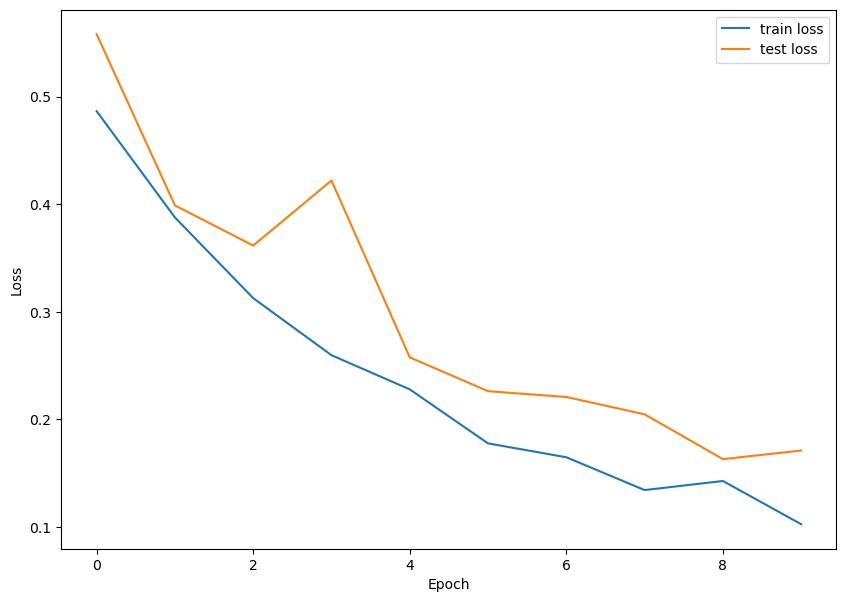

In [126]:
# loss 체크

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(n_epoch), history.history['loss'], label='train loss')
plt.plot(range(n_epoch), history.history['val_loss'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [127]:
#Accuracy of the predicted values
y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        77
           1       0.88      0.96      0.92        23
           2       0.96      0.97      0.97       328
           3       0.75      1.00      0.86         3

    accuracy                           0.94       431
   macro avg       0.86      0.92      0.89       431
weighted avg       0.93      0.94      0.93       431

[[ 59   3  14   1]
 [  1  22   0   0]
 [  9   0 319   0]
 [  0   0   0   3]]
